# Bean Leaf Classification

In [1]:
import numpy as np
import evaluate
import torch

from datasets import load_dataset
from transformers import TrainingArguments
from transformers import Trainer
from transformers import ViTFeatureExtractor, ViTForImageClassification


In [2]:
dataset = load_dataset("beans")

Using custom data configuration default
Reusing dataset beans (C:\Users\Teuku Rizky\.cache\huggingface\datasets\beans\default\0.0.0\90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
print(dataset["train"])

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 1034
})


We have 1034 training samples

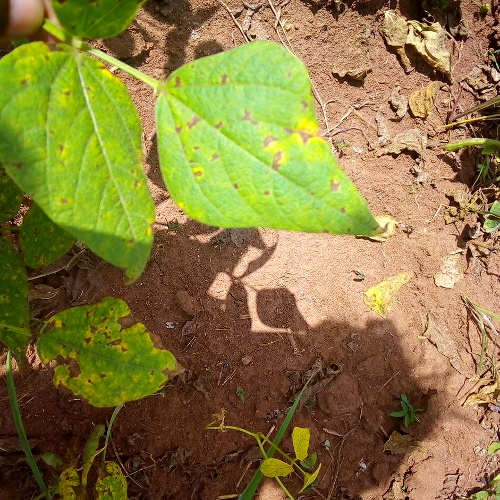

0


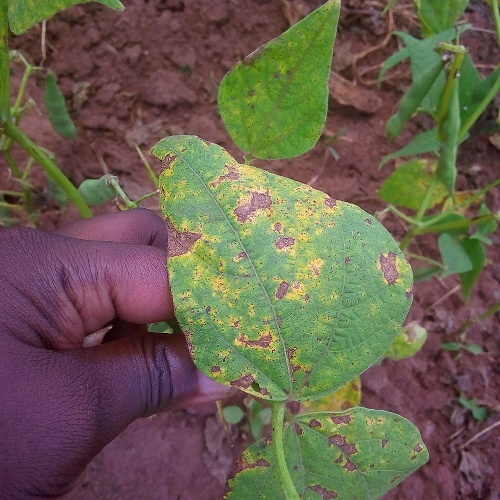

0


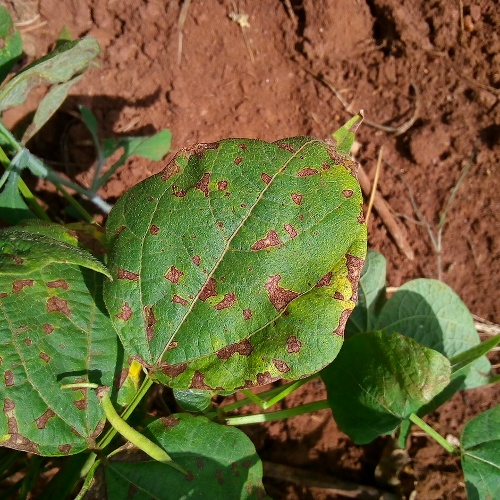

0


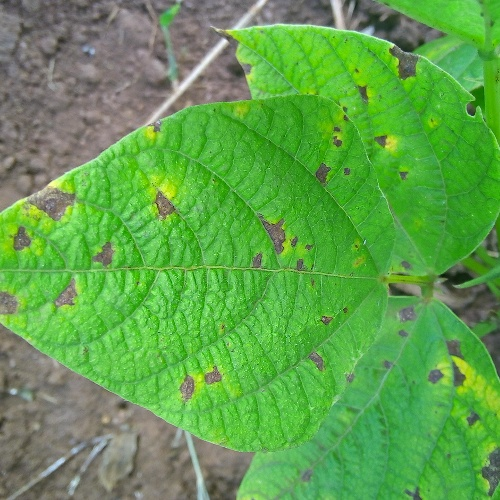

0


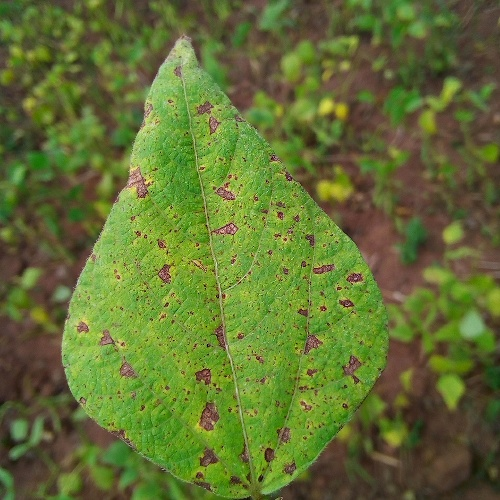

0


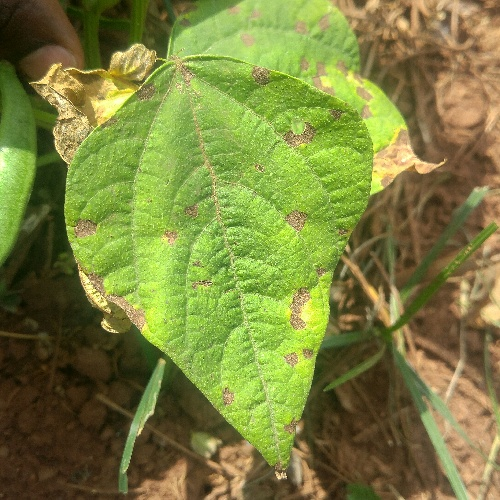

0


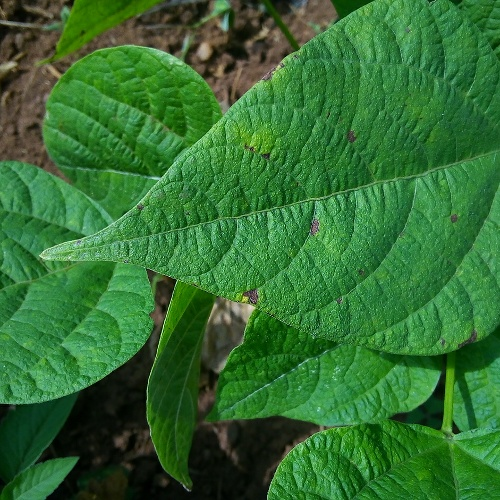

0


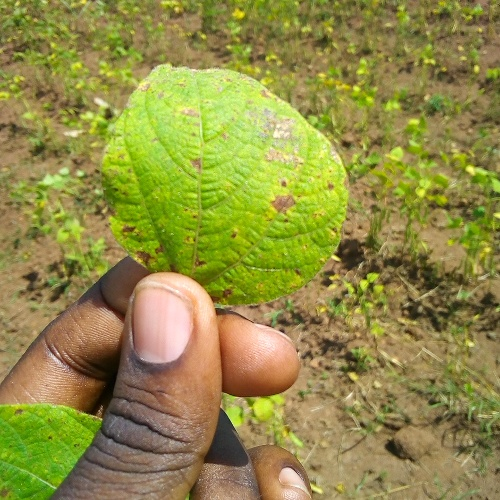

0


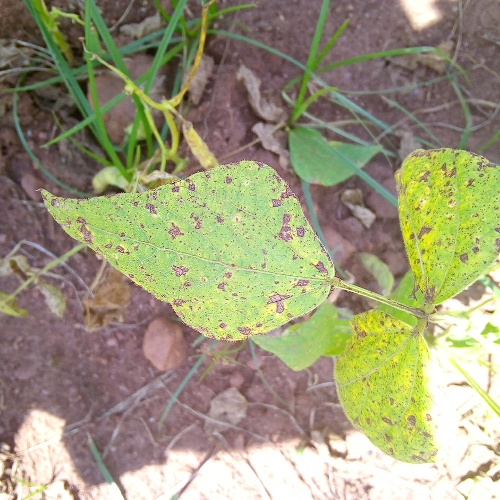

0


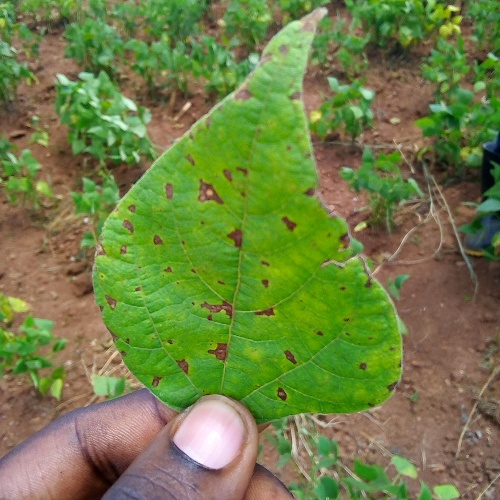

0


In [4]:
for i in range(10):
  display(dataset['train'][i]['image'])
  print(dataset["train"][i]["labels"])

In [5]:
#device = torch.device('cuda')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
#model.eval()
#model.to(device);

In [6]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

In [7]:
# First we get the features corresponding to the first training image
encoding = feature_extractor(images=dataset['train'][1]['image'], return_tensors="pt")

In [8]:
with torch.no_grad():
    logits = model(**encoding).logits

In [9]:
prediction = logits.argmax(-1).item()

print("Predicted class:", model.config.id2label[prediction])

Predicted class: ear, spike, capitulum


In [10]:
def transform(example_batch):
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = dataset.with_transform(transform)

In [11]:
metric = evaluate.load("accuracy")

def compute_metrics(sample):
    return metric.compute(
        predictions=np.argmax(sample.predictions, axis=1), 
        references=sample.label_ids)

In [12]:
training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

Using amp half precision backend


In [13]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

c:\python\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1034
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 260


  0%|          | 0/260 [00:00<?, ?it/s]

{'loss': 2.9329, 'learning_rate': 0.0001930769230769231, 'epoch': 0.15}
{'loss': 0.4999, 'learning_rate': 0.0001853846153846154, 'epoch': 0.31}
{'loss': 0.4299, 'learning_rate': 0.0001776923076923077, 'epoch': 0.46}
{'loss': 0.2289, 'learning_rate': 0.00017, 'epoch': 0.62}
{'loss': 0.2064, 'learning_rate': 0.0001623076923076923, 'epoch': 0.77}
{'loss': 0.1216, 'learning_rate': 0.00015461538461538464, 'epoch': 0.92}
{'loss': 0.1396, 'learning_rate': 0.00014692307692307693, 'epoch': 1.08}
{'loss': 0.1059, 'learning_rate': 0.00013923076923076923, 'epoch': 1.23}
{'loss': 0.0462, 'learning_rate': 0.00013153846153846156, 'epoch': 1.38}


***** Running Evaluation *****
  Num examples = 133
  Batch size = 8


{'loss': 0.229, 'learning_rate': 0.00012384615384615385, 'epoch': 1.54}


  0%|          | 0/17 [00:00<?, ?it/s]

Saving model checkpoint to ./vit-base-beans\checkpoint-100
Configuration saved in ./vit-base-beans\checkpoint-100\config.json


{'eval_loss': 0.17672432959079742, 'eval_accuracy': 0.9624060150375939, 'eval_runtime': 15.2881, 'eval_samples_per_second': 8.7, 'eval_steps_per_second': 1.112, 'epoch': 1.54}


Model weights saved in ./vit-base-beans\checkpoint-100\pytorch_model.bin
Configuration saved in ./vit-base-beans\checkpoint-100\preprocessor_config.json


{'loss': 0.1872, 'learning_rate': 0.00011615384615384617, 'epoch': 1.69}
{'loss': 0.1611, 'learning_rate': 0.00010846153846153846, 'epoch': 1.85}
{'loss': 0.0968, 'learning_rate': 0.00010076923076923077, 'epoch': 2.0}
{'loss': 0.0639, 'learning_rate': 9.307692307692309e-05, 'epoch': 2.15}
{'loss': 0.0019, 'learning_rate': 8.538461538461538e-05, 'epoch': 2.31}
{'loss': 0.0021, 'learning_rate': 7.76923076923077e-05, 'epoch': 2.46}
{'loss': 0.0131, 'learning_rate': 7e-05, 'epoch': 2.62}
{'loss': 0.0636, 'learning_rate': 6.23076923076923e-05, 'epoch': 2.77}
{'loss': 0.0006, 'learning_rate': 5.461538461538461e-05, 'epoch': 2.92}


***** Running Evaluation *****
  Num examples = 133
  Batch size = 8


{'loss': 0.0167, 'learning_rate': 4.692307692307693e-05, 'epoch': 3.08}


  0%|          | 0/17 [00:00<?, ?it/s]

Saving model checkpoint to ./vit-base-beans\checkpoint-200
Configuration saved in ./vit-base-beans\checkpoint-200\config.json


{'eval_loss': 0.11509539186954498, 'eval_accuracy': 0.9774436090225563, 'eval_runtime': 14.6308, 'eval_samples_per_second': 9.09, 'eval_steps_per_second': 1.162, 'epoch': 3.08}


Model weights saved in ./vit-base-beans\checkpoint-200\pytorch_model.bin
Configuration saved in ./vit-base-beans\checkpoint-200\preprocessor_config.json


{'loss': 0.0019, 'learning_rate': 3.923076923076923e-05, 'epoch': 3.23}
{'loss': 0.0226, 'learning_rate': 3.153846153846154e-05, 'epoch': 3.38}
{'loss': 0.0009, 'learning_rate': 2.384615384615385e-05, 'epoch': 3.54}
{'loss': 0.0002, 'learning_rate': 1.6153846153846154e-05, 'epoch': 3.69}
{'loss': 0.0003, 'learning_rate': 8.461538461538462e-06, 'epoch': 3.85}




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./vit-base-beans\checkpoint-200 (score: 0.11509539186954498).


{'loss': 0.0005, 'learning_rate': 7.692307692307694e-07, 'epoch': 4.0}


Saving model checkpoint to ./vit-base-beans
Configuration saved in ./vit-base-beans\config.json


{'train_runtime': 1365.2162, 'train_samples_per_second': 3.03, 'train_steps_per_second': 0.19, 'train_loss': 0.21437068414301252, 'epoch': 4.0}


Model weights saved in ./vit-base-beans\pytorch_model.bin
Configuration saved in ./vit-base-beans\preprocessor_config.json


***** train metrics *****
  epoch                    =        4.0
  train_loss               =     0.2144
  train_runtime            = 0:22:45.21
  train_samples_per_second =       3.03
  train_steps_per_second   =       0.19


In [37]:
eval_accuracy = trainer.evaluate()

***** Running Evaluation *****
  Num examples = 133
  Batch size = 8


{'eval_loss': 0.115058034658432, 'eval_accuracy': 0.9774436090225563, 'eval_runtime': 14.4887, 'eval_samples_per_second': 9.18, 'eval_steps_per_second': 1.173, 'epoch': 0.02}


In [36]:
test_accuracy = trainer.predict(prepared_ds["test"])

***** Running Prediction *****
  Num examples = 128
  Batch size = 8


In [39]:
test_accuracy.metrics

{'test_loss': 0.14023026823997498,
 'test_accuracy': 0.9609375,
 'test_runtime': 13.457,
 'test_samples_per_second': 9.512,
 'test_steps_per_second': 1.189}